# A Metric over Cloud Systems

Because the autoencoder has a small field of view, we can only analyze the latent space in patches so small that it is extremely difficult to recover the macro system that generated the patch. The categories found by the clusters of encoded patches do not well separate open vs closed cell stratocumulus, however maybe the distribution of many patches drawn from the same system can identify the macrosystem.

In this notebook, we will cut up stratocumulus systems and examine the learned cluster distribution and compare the differences using the Wasserstien metric (ie. Earth mover's distance). This is a bit like taking images of stratocumulus, cutting it up into jigsaw pieces and giving a bag of those pieces to a human and asking if the original system was open cell or closed cell. It might be pretty difficult, but at least its easier than if we only gave one jigsaw piece.

With a metric defined, we can go through another level of clustering or KNN classifying, this time in "histogram space".

Other good metric -- mutual information (but the stats interpretation is weirder)

In [10]:
sys.path.insert(1, os.path.join(sys.path[0], ".."))

In [62]:
import os, sys, glob

from reproduction.pipeline import into_record
from reproduction.utils import load_model_def
from reproduction import analysis

from sklearn.cluster import KMeans
from scipy.stats import wasserstein_distance

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [28]:
encoder = load_model_def("../output/mod09cnn15b/", "encoder", True)

open_tifs = glob.glob("../data/closed_open_cell/*open-cell.tif")
clos_tifs = glob.glob("../data/closed_open_cell/*closed-cell.tif")

# Use kmeans centers trained on spatially averaged encodings on whole training set
kmc = analysis.read_kmeans_centers("../output/m15b-enc.cluster_centres")
k_means = KMeans(n_clusters=kmc.shape[0], init=kmc)
k_means.cluster_centers_ = kmc

SHAPE = 128, 128

In [44]:
def cluster_distribution(tif):
    """Returns a distribution vector.
    `distribution[i]` is the percentage of patches in `tif` that belong to category `i`.
    """
    swath = into_record.gen_swaths([tif], mode="mod09_tif", resize=1)
    patches = into_record.gen_patches(swath, SHAPE, strides=SHAPE)
    latents = encoder.predict(np.stack([p[2] for p in patches], axis=0))
    labels = k_means.predict(latents.mean(axis=(1,2)))
    distribution = np.unique(labels, return_counts=True)[1]
    return distribution / distribution.sum()

In [45]:
o_distributions = [cluster_distribution(t) for t in open_tifs]

rank 0 reading ../data/closed_open_cell/2017-01-13_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-05_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-29_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-21_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-11_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-07_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-23_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-19_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-09_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-25_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-17_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-01_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-31_MOD09GA_open-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-27_

In [53]:
c_distributions = [cluster_distribution(t) for t in clos_tifs]

rank 0 reading ../data/closed_open_cell/2017-01-05_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-27_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-19_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-16_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-28_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-30_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-01_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-12_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-23_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-11_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-20_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-02_MOD09GA_closed-cell.tif
rank 0 reading ../data/closed_open_cell/2017-01-24_MOD09GA_closed-cell.tif
rank 0 reading ../data/cl

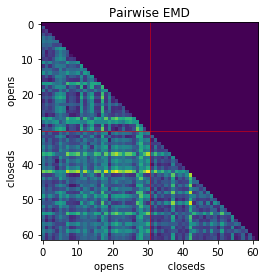

In [135]:
distributions = o_distributions + c_distributions
emd = np.zeros((len(distributions), len(distributions)))

for i, x in enumerate(distributions):
    for j, y in enumerate(distributions[:i]):
        emd[i, j] = wasserstein_distance(x, y)

plt.imshow(emd, )
plt.axvline(len(o_distributions)-0.5, c="red", linewidth=0.5)
plt.axhline(len(o_distributions)-0.5, c="red", linewidth=0.5)
plt.xlabel("opens              closeds")
plt.ylabel("closeds              opens")
plt.title("Pairwise EMD");

Looking at the pairwise earth movers distance, it doesn't seem like the interclass distances (lower left) are significantly higher than the intraclass distances

/anaconda3/envs/clouds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


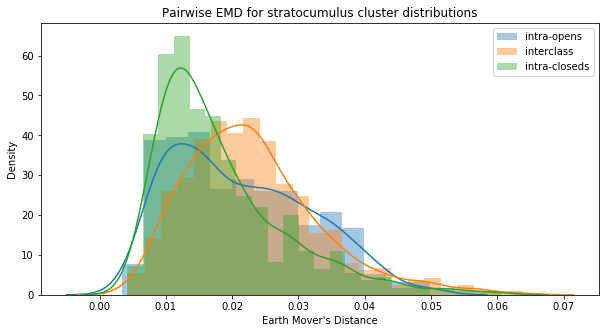

In [141]:
ds = {}
ds["intra-opens"]   = [wasserstein_distance(x,y) for x in o_distributions for y in o_distributions if x is not y]
ds["interclass"]    = [wasserstein_distance(x,y) for x in o_distributions for y in c_distributions if x is not y]
ds["intra-closeds"] = [wasserstein_distance(x,y) for x in c_distributions for y in c_distributions if x is not y]

plt.figure(figsize=(10, 5))
for i, h in ds.items():
    seaborn.distplot(h, label=i, norm_hist=True)
plt.ylabel("Density")
plt.xlabel("Earth Mover's Distance")
plt.title("Pairwise EMD for stratocumulus cluster distributions")
plt.legend()

We want this orange histogram to be far to the right so we could argue that systems of the same class have similar distributions over clusters while open vs closed cell systems have very different cluster distributions.